## Tratamento dos dados

### Importando bibliotecas

In [1]:
import numpy as np
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
def inicializacao_matriz_pertinencia(num_amostras, num_clusters):
    matriz_pertinencia = np.random.rand(num_amostras, num_clusters) # gera uma matriz inicial aleatória com valores entre 0 e 1
    matriz_pertinencia = matriz_pertinencia / matriz_pertinencia.sum(axis=1, keepdims=True) # normalização da matriz pra garantir que a soma dos graus dê um
    return matriz_pertinencia
def inicializacao_pesos(num_clusters, num_variaveis):
    pesos = np.ones((num_clusters, num_variaveis)) # inicializa os pesos com 1
    return pesos
def atualizacao_centroides(dados, matriz_pertinencia, m):
    matriz_pertinencia_m = matriz_pertinencia ** m # preparação dos graus de pertinência
    centroides = np.dot(matriz_pertinencia_m.T, dados) / np.sum(matriz_pertinencia_m.T, axis=1, keepdims=True) # fórmula para o cálculo dos centroides
    return centroides
def atualizacao_matriz_pertinencia(dados, centroides, pesos, m):
    diff_sq = (dados[:, np.newaxis, :] - centroides) ** 2 # (xjk - yij)^2
    weighted_diff_sq = pesos * diff_sq # λij
    matriz_distancias = np.sum(weighted_diff_sq, axis=2) # \sum_{j=1}^p
    matriz_distancias = np.fmax(matriz_distancias, np.finfo(np.float64).eps) # evita que matriz_distancias seja 0, np.finfo... é o menor número maior que zero aaqui
    matriz_distancias_inversa = 1 / matriz_distancias
    potencia = 1 / (m-1)
    matriz_pertinencia_atualizada = matriz_distancias_inversa ** potencia / np.sum(matriz_distancias_inversa ** potencia, axis=1, keepdims=True) # fórmula para atualizar os graus de pertinência
    return matriz_pertinencia_atualizada
def atualizacao_pesos(dados, centroides, matriz_pertinencia, m):
    num_amostras, num_variaveis = dados.shape
    num_clusters = centroides.shape[0]

    # D[i, j] = sum_k( (u_ik)^m * (x_jk - y_ij)^2 )
    
    matriz_pertinencia_m = matriz_pertinencia ** m
    diff_sq = (dados[:, np.newaxis, :] - centroides) ** 2
    weighted_diff_sq = matriz_pertinencia_m[:, :, np.newaxis] * diff_sq

    D = np.sum(weighted_diff_sq, axis=0) # (C, P)
    D = np.fmax(D, np.finfo(np.float64).eps)

    # Numerador_i = { Prod_h( D_ih ) } ^ (1/p)
    # logaritmos para estabilidade numérica (evita underflow/overflow)
    # log(Numerador_i) = (1/p) * sum_h( log(D_ih) )
    
    log_D = np.log(D)
    soma_log_D = np.sum(log_D, axis=1) # soma os logs das dispersões sobre as variáveis 'h' (axis=1)
    numerador = np.exp(soma_log_D / num_variaveis) # média geométrica

    pesos = numerador[:, np.newaxis] / D # peso final
     
    return pesos
def fcm(dados, num_clusters, m=2, max_iter=10**6, erro=1e-9):
    num_amostras, num_variaveis = dados.shape
    matriz_pertinencia = inicializacao_matriz_pertinencia(num_amostras, num_clusters)
    pesos = inicializacao_pesos(num_clusters, num_variaveis)
    for _ in range(max_iter): # primeiro critério de parada
        centroides = atualizacao_centroides(dados, matriz_pertinencia, m)
        pesos = atualizacao_pesos(dados, centroides, matriz_pertinencia, m)
        nova_matriz_pertinencia = atualizacao_matriz_pertinencia(dados, centroides, pesos, m)
        if np.linalg.norm(nova_matriz_pertinencia - matriz_pertinencia) < erro: # segundo critério de parada
            break
        matriz_pertinencia = nova_matriz_pertinencia
    return centroides, matriz_pertinencia, pesos
def indice_rand(labels, predicted_labels):
    return adjusted_rand_score(labels, predicted_labels)
def simulacao_monte_carlo(dados, labels, num_clusters, num_trials):
    ari = []
    ami = []
    for _ in range(num_trials):
        centroides, matriz_pertinencia, pesos = fcm(dados, num_clusters)
        predicted_labels = np.argmax(matriz_pertinencia, axis=1)
        idx_rand = indice_rand(labels, predicted_labels)
        ari.append(idx_rand)
        ami_rand = adjusted_mutual_info_score(labels, predicted_labels)
        ami.append(ami_rand)
    mean_ari = np.mean(ari)
    std_ari = np.std(ari)
    mean_ami = np.mean(ami)
    std_ami = np.std(ami)
    return mean_ari, std_ari, mean_ami, std_ami

In [3]:
def gerar_configuracao(mu_list, sigma_list, tamanhos, config_id):
    dfs = []
    for i, (mu, sigma2, n) in enumerate(zip(mu_list, sigma_list, tamanhos)):
        Sigma = np.diag(sigma2)
        data = np.random.multivariate_normal(mu, Sigma, n)
        df = pd.DataFrame(data, columns=["x1", "x2"])
        df["class"] = i + 1
        dfs.append(df)
    df_config = pd.concat(dfs, ignore_index=True)
    df_config["config"] = config_id
    return df_config

np.random.seed(42)  # reprodutibilidade

# Configuração 1
mu_1 = [[5, 0], [15, 5], [18, 14]]
sigma2_1 = [[81, 9], [9, 100], [25, 36]]
n1 = [200, 100, 50]
df1 = gerar_configuracao(mu_1, sigma2_1, n1, config_id=1)
l1 = "Classes elípticas de tamanhos diferentes"

# Configuração 2
mu_2 = [[0, 0], [30, 0], [12, 25]]
sigma2_2 = [[100, 100], [49, 49], [16, 16]]
n2 = [200, 100, 50]
df2 = gerar_configuracao(mu_2, sigma2_2, n2, config_id=2)
l2 = "Classes esféricas de tamanhos diferentes"

# Configuração 3
mu_3 = [[0, 0], [15, 5], [15, -5]]
sigma2_3 = [[100, 4], [100, 4], [100, 4]]
n3 = [100, 100, 100]
df3 = gerar_configuracao(mu_3, sigma2_3, n3, config_id=3)
l3 = "Classes elípticas de tamanhos iguais"

# Configuração 4
mu_4 = [[0, 0], [15, 0], [-15, 0]]
sigma2_4 = [[16, 16], [16, 16], [16, 16]]
n4 = [100, 100, 100]
df4 = gerar_configuracao(mu_4, sigma2_4, n4, config_id=4)
l4 = "Classes esféricas de tamanhos iguais"

# Configuração 5
mu_5 = [[5, 0], [15, 5], [10, -7], [3, 15]]
sigma2_5 = [[81, 9], [9, 100], [49, 16], [25, 25]]
n5 = [50, 50, 50, 50]
df5 = gerar_configuracao(mu_5, sigma2_5, n5, config_id=5)
l5 = "3 classes elípticas e 1 esférica"

# Configuração 6
mu_6 = [[5, 0], [15, 5], [12, -12], [7, 17]]
sigma2_6 = [[81, 9], [9, 100], [16, 16], [25, 25]]
n6 = [50, 50, 50, 50]
df6 = gerar_configuracao(mu_6, sigma2_6, n6, config_id=6)
l6 = "2 classes elípticas e 2 esféricas"

# Configuração 7
mu_7 = [[0, 0], [18, 0], [-18, 0], [0, -12]]
sigma2_7 = [[12, 12], [20, 20], [16, 16], [81, 20]]
n7 = [50, 50, 50, 50]
df7 = gerar_configuracao(mu_7, sigma2_7, n7, config_id=7)
l7 = "1 classe elíptica e 3 esféricas"

In [4]:
i = 1
for df in [df1, df2, df3, df4, df5, df6, df7]:
    np.random.seed(42)  # reprodutibilidade
    df.drop("config", axis=1, inplace=True)  # remove a coluna de configuração
    labels = df["class"].values
    num_clusters = len(df[df['class'] != 0]['class'].unique())  # número de clusters, excluindo o ruído
    df.drop("class", axis=1, inplace=True)  # remove a coluna de classe
    dados = df.to_numpy()
    num_trials = 100
    mean_ari, std_ari, mean_ami, std_ami = simulacao_monte_carlo(dados, labels, num_clusters, num_trials)
    print(f"Configuração {i}")
    print(f"ARI mean: {mean_ari:.4f}")
    print(f"ARI std: {std_ari:.4f}")
    print(f"AMI mean: {mean_ami:.4f}")
    print(f"AMI std: {std_ami:.4f}")
    print("")
    i +=1

Configuração 1
ARI mean: 0.3720
ARI std: 0.0000
AMI mean: 0.4347
AMI std: 0.0000

Configuração 2
ARI mean: 0.6350
ARI std: 0.0000
AMI mean: 0.6262
AMI std: 0.0000

Configuração 3
ARI mean: 0.7042
ARI std: 0.0000
AMI mean: 0.6568
AMI std: 0.0000

Configuração 4
ARI mean: 0.6587
ARI std: 0.2023
AMI mean: 0.6444
AMI std: 0.1629

Configuração 5
ARI mean: 0.4745
ARI std: 0.0397
AMI mean: 0.4986
AMI std: 0.0261

Configuração 6
ARI mean: 0.4503
ARI std: 0.0000
AMI mean: 0.5103
AMI std: 0.0000

Configuração 7
ARI mean: 0.7758
ARI std: 0.0000
AMI mean: 0.7568
AMI std: 0.0000



--- ANÁLISE DA CONFIGURAÇÃO 7 ---
Parâmetros de Geração (Variâncias Sigma^2):
Classe 1 (id 1): [100, 4] (Esférica)
Classe 2 (id 2): [100, 4] (Esférica)
Classe 3 (id 3): [100, 4] (Esférica)
Executando FCM-C2...
Algoritmo convergiu em 68 iterações.
Execução concluída.

--- PESOS FINAIS (lambda_ij) ---
O peso lambda_ij é ~inverso da variância (dispersão) do cluster.
Peso [Pequeno] = Muita variância (eixo esticado)
Peso [Grande]  = Pouca variância (eixo compacto)

           Peso Var 0 (x1)  Peso Var 1 (x2)
Cluster 0         0.217429         4.599193
Cluster 1         0.224285         4.458616
Cluster 2         0.269649         3.708519

Gerando visualização...


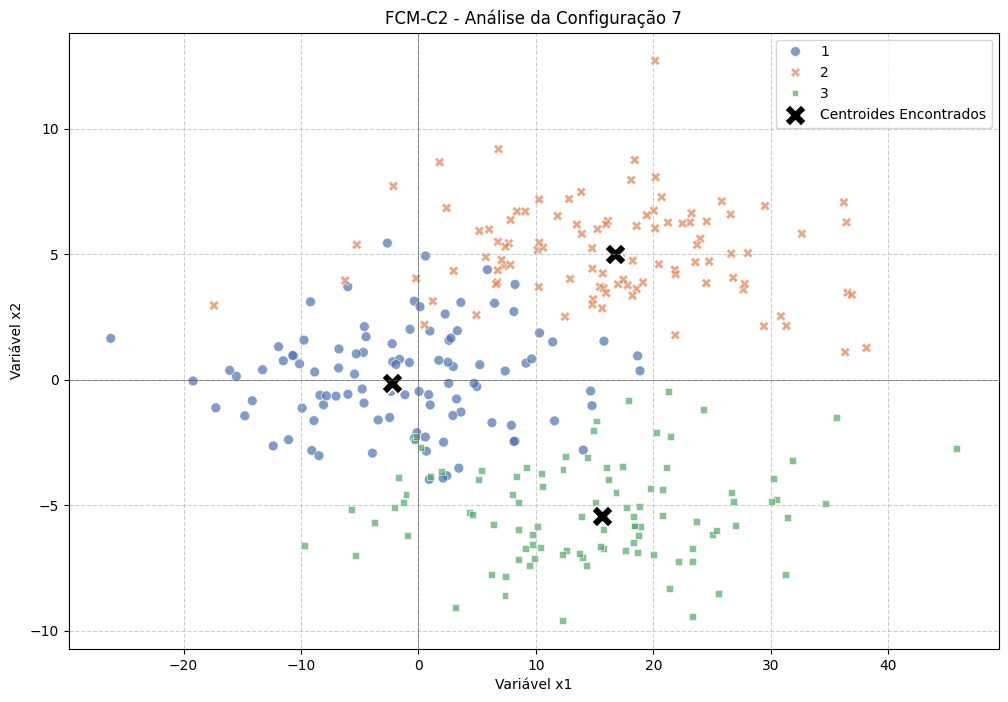

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

# -------------------------------------------------------------------
# Funções de Implementação do FCM-C2 (Conforme o seu código)
# -------------------------------------------------------------------

def inicializacao_matriz_pertinencia(num_amostras, num_clusters):
    """
    Inicializa a matriz de pertinência U aleatoriamente, garantindo que
    a soma das pertinências para cada amostra (linha) seja 1.
    """
    matriz_pertinencia = np.random.rand(num_amostras, num_clusters)
    matriz_pertinencia = matriz_pertinencia / matriz_pertinencia.sum(axis=1, keepdims=True)
    return matriz_pertinencia

def inicializacao_pesos(num_clusters, num_variaveis):
    """
    Inicializa a matriz de pesos lambda_ij (C, P) com 1s,
    conforme o Algoritmo 3 da tese.
    """
    pesos = np.ones((num_clusters, num_variaveis))
    return pesos

def atualizacao_centroides(dados, matriz_pertinencia, m):
    """
    Atualiza os centroides (protótipos) y_i.
    Implementa a Equação 2.10.
    """
    matriz_pertinencia_m = matriz_pertinencia ** m
    
    numerador = np.dot(matriz_pertinencia_m.T, dados)
    denominador = np.sum(matriz_pertinencia_m.T, axis=1, keepdims=True)
    
    # --- CORREÇÃO DE ESTABILIDADE ---
    # Impede a divisão por zero se um cluster ficar vazio (denominador = 0)
    denominador = np.fmax(denominador, np.finfo(np.float64).eps)
    
    centroides = numerador / denominador
    return centroides

def atualizacao_matriz_pertinencia(dados, centroides, pesos, m):
    """
    Atualiza a matriz de pertinência u_ik.
    Implementa a Equação 2.14 (FCM-C2).
    """
    # (x_jk - y_ij)^2 - Shape (N, C, P)
    diff_sq = (dados[:, np.newaxis, :] - centroides) ** 2
    
    # lambda_ij * (x_jk - y_ij)^2 - Shape (N, C, P)
    # pesos (C, P) é transmitido (broadcasted) por N
    weighted_diff_sq = pesos * diff_sq
    
    # d_ik = sum_j( lambda_ij * (x_jk - y_ij)^2 ) - Shape (N, C)
    matriz_distancias = np.sum(weighted_diff_sq, axis=2)
    
    # Proteção contra divisão por zero
    matriz_distancias = np.fmax(matriz_distancias, np.finfo(np.float64).eps)
    
    # Implementação da fórmula transformada (vetorizada):
    # u_ik = (1/d_ik)^P / sum_h( (1/d_hk)^P )
    matriz_distancias_inversa = 1 / matriz_distancias
    potencia = 1 / (m - 1)
    
    matriz_pertinencia_atualizada = matriz_distancias_inversa ** potencia / np.sum(matriz_distancias_inversa ** potencia, axis=1, keepdims=True)
    
    # Normalização final para garantir que a soma seja 1 (segurança numérica)
    matriz_pertinencia_atualizada = matriz_pertinencia_atualizada / np.sum(matriz_pertinencia_atualizada, axis=1, keepdims=True)
    
    return matriz_pertinencia_atualizada

def atualizacao_pesos(dados, centroides, matriz_pertinencia, m):
    """
    Atualiza os pesos lambda_ij.
    Implementa a Equação 2.15 (FCM-C2).
    """
    num_amostras, num_variaveis = dados.shape
    num_clusters = centroides.shape[0]

    # --- 1. Calcular Denominador D_ij ---
    # D[i, j] = sum_k( (u_ik)^m * (x_jk - y_ij)^2 )
    
    matriz_pertinencia_m = matriz_pertinencia ** m
    diff_sq = (dados[:, np.newaxis, :] - centroides) ** 2
    
    # Alinhamento para (N, C, 1) * (N, C, P) -> (N, C, P)
    weighted_diff_sq = matriz_pertinencia_m[:, :, np.newaxis] * diff_sq

    # Somar sobre as amostras 'k' (axis=0)
    D = np.sum(weighted_diff_sq, axis=0) # Shape: (C, P)
    
    # Proteção contra valores muito pequenos
    D = np.fmax(D, np.finfo(np.float64).eps)

    # --- 2. Calcular Numerador (Média Geométrica) ---
    # Numerador_i = { Prod_h( D_ih ) } ^ (1/p)
    # Implementado via logs para estabilidade numérica
    
    log_D = np.log(D)
    soma_log_D = np.sum(log_D, axis=1) # Soma sobre as variáveis 'h'
    numerador = np.exp(soma_log_D / num_variaveis) # Média geométrica

    # --- 3. Calcular Peso Final ---
    # lambda_ij = Numerador[i] / Denominador[i, j]
    pesos = numerador[:, np.newaxis] / D # Shape (C, 1) / (C, P)
     
    return pesos

def fcm_c2(dados, num_clusters, m=2, max_iter=10**6, erro=1e-9):
    """
    Função principal do loop do FCM-C2.
    """
    num_amostras, num_variaveis = dados.shape
    
    # Inicializações
    matriz_pertinencia = inicializacao_matriz_pertinencia(num_amostras, num_clusters)
    pesos = inicializacao_pesos(num_clusters, num_variaveis)
    
    for i in range(max_iter):
        # Etapa 6: Atualizar Protótipos
        centroides = atualizacao_centroides(dados, matriz_pertinencia, m)
        
        # Etapa 7: Atualizar Pesos
        pesos = atualizacao_pesos(dados, centroides, matriz_pertinencia, m)
        
        # Etapa 8: Atualizar Matriz de Pertinência
        nova_matriz_pertinencia = atualizacao_matriz_pertinencia(dados, centroides, pesos, m)
        
        # Etapa 9: Verificar parada
        if np.linalg.norm(nova_matriz_pertinencia - matriz_pertinencia) < erro:
            print(f"Algoritmo convergiu em {i+1} iterações.")
            break
            
        matriz_pertinencia = nova_matriz_pertinencia
        
    return centroides, matriz_pertinencia, pesos

# -------------------------------------------------------------------
# Funções de Geração de Dados (Conforme o seu código)
# -------------------------------------------------------------------

def gerar_configuracao(mu_list, sigma_list, tamanhos, config_id):
    dfs = []
    # Nota: sigma_list contém as variâncias (sigma^2), não o desvio padrão.
    for i, (mu, sigma2, n) in enumerate(zip(mu_list, sigma_list, tamanhos)):
        # np.diag(sigma2) cria a matriz de covariância diagonal
        Sigma = np.diag(sigma2) 
        data = np.random.multivariate_normal(mu, Sigma, n)
        df = pd.DataFrame(data, columns=["x1", "x2"])
        df["class"] = i + 1 # Rótulo da classe (1-based)
        dfs.append(df)
    df_config = pd.concat(dfs, ignore_index=True)
    df_config["config"] = config_id
    return df_config

# -------------------------------------------------------------------
# ANÁLISE DA CONFIGURAÇÃO 7
# -------------------------------------------------------------------

if __name__ == "__main__":
    np.random.seed(42)
    
    # Definição da Configuração 7
    # Definição da Configuração 7
    mu_3 = [[0, 0], [15, 5], [15, -5]]
    sigma2_3 = [[100, 4], [100, 4], [100, 4]]
    n3 = [100, 100, 100]
    df3 = gerar_configuracao(mu_3, sigma2_3, n3, config_id=3)
    
    print("--- ANÁLISE DA CONFIGURAÇÃO 7 ---")
    print("Parâmetros de Geração (Variâncias Sigma^2):")
    print(f"Classe 1 (id 1): {sigma2_3[0]} (Esférica)")
    print(f"Classe 2 (id 2): {sigma2_3[1]} (Esférica)")
    print(f"Classe 3 (id 3): {sigma2_3[2]} (Esférica)")
    
    # Preparar dados para o FCM-C2
    labels = df3["class"].values
    dados = df3.drop(columns=["class", "config"]).to_numpy()
    num_clusters = len(np.unique(labels)) # 4 clusters
    
    # --- 1. Executar o FCM-C2 (uma única vez) ---
    print("Executando FCM-C2...")
    centroides_finais, pertinencia_final, pesos_finais = fcm_c2(dados, num_clusters)
    print("Execução concluída.\n")
    
    # --- 2. Análise dos Pesos (lambda_ij) ---
    print("--- PESOS FINAIS (lambda_ij) ---")
    print("O peso lambda_ij é ~inverso da variância (dispersão) do cluster.")
    print("Peso [Pequeno] = Muita variância (eixo esticado)")
    print("Peso [Grande]  = Pouca variância (eixo compacto)\n")
    
    # Mapear os rótulos 1,2,3,4 para os índices 0,1,2,3
    # NOTA: A ordem dos clusters encontrados pelo FCM pode não ser a mesma 
    # dos rótulos originais (1,2,3,4). Vamos analisar os pesos como o 
    # algoritmo os encontrou (Cluster 0, Cluster 1, Cluster 2, Cluster 3).
    
    print(pd.DataFrame(pesos_finais, 
                       columns=["Peso Var 0 (x1)", "Peso Var 1 (x2)"],
                       index=[f"Cluster {i}" for i in range(num_clusters)]))
    
    # --- 3. Visualização ---
    print("\nGerando visualização...")
    
    # Converter centroides para DataFrame para plotting fácil
    df_centroides = pd.DataFrame(centroides_finais, columns=["x1", "x2"])
    
    plt.figure(figsize=(12, 8))
    
    # Plotar os dados originais (ground truth)
    sns.scatterplot(data=df3, x="x1", y="x2", hue="class", 
                    palette="deep", s=50, alpha=0.7, style="class",
                    legend="full")
    
    # Plotar os centróides encontrados
    sns.scatterplot(data=df_centroides, x="x1", y="x2", 
                    marker="X", s=250, color="black", 
                    label="Centroides Encontrados")
    
    plt.title("FCM-C2 - Análise da Configuração 7")
    plt.xlabel("Variável x1")
    plt.ylabel("Variável x2")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.axhline(0, color='black', linewidth=0.5, alpha=0.5)
    plt.axvline(0, color='black', linewidth=0.5, alpha=0.5)
    plt.legend()
    plt.show()